# Ortholog Finding
#### This module was originally created for cas9 but could extended to any protein.

## Step 1: Profile the Protein
    1. Mean, max, min length of already known orthologs
## Step 2: HMM Seach
    1. Align orthologs
    2. build hmm profile
    3. hmm search against a database
## Step 3: Profile Results
    1. Read hmm results
    2. cluster results by percent identity
    3. remove proteins without required domains


### Env

<p>
conda create --name casenv <br/>
conda install -n casenv libgcc hmmer mafft biopython <br/>
source activate casenv
</p>

In [1]:
%matplotlib inline
import re
import sys
sys.path.append("scripts/")

from Bio.SeqIO import write, parse
from collections import Counter
from easyFunctions import *
from HMMParser import *
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from os import chdir

chdir("data")

### Gene Orthologs Fasta File

In [2]:
gene = "Cas9"
geneProfile = "sequences/DiverseCas9s.faa" #File containing the seed proteins for the hmmsearch
geneFile = "proteins/%s.faa" % gene
alnName  = "alignments/%s.aln" % gene
hmmName  = "domains/%s.hmm" % gene
hmmResultsDir = "hmm/results/"
refDatabase = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
#refDatabase = "/mnt/research/germs/shane/databases/assemblies/PATRIC2/fastas"

### Profile the gene

In [3]:
from Bio.SeqIO import parse
from pandas import Series
dists = []
for rec in parse(geneProfile,"fasta"):dists.append(len(rec.seq))
dists = Series(dists)
minSeqLen = int(dists.min() - (dists.mean() * .2))
maxSeqLen = int(dists.max() + (dists.mean() * .2))
print dists.describe();
print "Finding proteins that match the protein profile and are between %i and %i" % (minSeqLen, maxSeqLen)

count      84.000000
mean     1243.547619
std       160.535955
min       984.000000
25%      1099.750000
50%      1207.500000
75%      1376.500000
max      1688.000000
dtype: float64
Finding proteins that match the protein profile and are between 735 and 1936


### Make HMM

In [13]:
%%bash -s $geneProfile $alnName $hmmName
source activate casenv
mafft --maxiterate 1000 --globalpair --reorder --treeout $1 > $2
hmmbuild $3 $2

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.1b2 (February 2015); http://hmmer.org/
# Copyright (C) 2015 Howard Hughes Medical Institute.
# Freely distributed under the GNU General Public License (GPLv3).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             DiverseCas9s.aln
# output HMM file:                  DiverseCas9s.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     DiverseCas9s            84  4253  1031     6.87  0.590 

# CPU time: 1.88u 0.00s 00:00:01.88 Elapsed: 00:00:01.91



All-to-all alignment.
tbfast-pair (aa) Version 7.313 alg=A, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
Gap Penalty = -1.53, +0.00, +0.00
treein = 0
compacttree = 0
Constructing a UPGMA tree ... 
   80 / 84
done.

Progressive alignment ... 
STEP    65 /83 c
Reallocating..done. *alloclen = 4506
STEP    72 /83 c
Reallocating..done. *alloclen = 5558
STEP    79 /83 c
Reallocating..done. *alloclen = 6606
STEP    83 /83 c
done.
tbfast (aa) Version 7.313 alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
Loading 'hat3' ... done.

   80 / 84
Segment   1/  1    1-4498
STEP 016-018-1  rejected.
Converged.

done
dvtditr (aa) Version 7.313 alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 G-INS-i (Sui

In [14]:
print minSeqLen, maxSeqLen, refDatabase
print hmmResultsDir, hmmName

735 1936 /mnt/research/germs/shane/databases/assemblies/PATRIC2/fastas
cas9/hmmResults/pat2 DiverseCas9s.hmm


### Do HMM search

In [15]:
%%bash -s $minSeqLen $maxSeqLen $refDatabase $hmmResultsDir $hmmName
echo -e """
source activate casenv
min=$1
max=$2
db=$3
outpath=$4
hmmName=$5
for f in $db/*.fasta; do
outfile="${f##*/}"
    if [ ! -f $outpath/$outfile.orfs ]; then
        #1 get the orfs
        python ~/bin/biopython_orf_find.py -min $min -max $max -i $f -o $outpath/$outfile.orfs >/dev/null
        #2 run the hmm against the orfs
        hmmsearch $hmmName $outpath/$outfile.orfs >$outpath/$outfile.out
    fi
done 
echo "Complete"
""" > ../scripts/hpc/HMMSearch.sub

qsub ../scripts/hpc/HMMSearch.sub

### Read the HMM Results and create fasta file

In [17]:
hmm_parser = HMM_Parser()
dirs = ["hmmSearch", "hmmSearch/pat2"]
for hmmResultsDir in dirs:
    files = os.listdir(hmmResultsDir)
    print "Working on the %s directory which contains %i files" % (hmmResultsDir,len(files))
    for fileName in files:
        if ".out" not in fileName:continue
        fileStats = os.stat(os.path.join(hmmResultsDir,fileName)).st_size  
        if fileStats < 1900:continue #Less than 1900 is no results found
        hmm_parser.parse(os.path.join(hmmResultsDir,fileName))

print "Writing proteins to file:", "%s-Like.faa" % gene
cas9Like = open("%s-Like.faa" % gene,"wb")
for result in hmm_parser.results:
    for prot in result.proteins:
        write(prot,cas9Like,"fasta")
cas9Like.close()   

Working on the hmmSearch directory which contains 222458 files
Working on the hmmSearch/pat2 directory which contains 319811 files
Writing proteins to file: Cas9-Like.faa


### Cluster the results

In [18]:
%%bash -s $gene
cd-hit -i proteins/$1-Like.faa -c .90 -d 0 -M 0 -T 0 -o proteins/$1-Like-clustered.faa >logs/ClusterLog.log
tail -n 8 logs/ClusterLog.log

    13649  finished       2670  clusters

Apprixmated maximum memory consumption: 390M
writing new database
writing clustering information
program completed !

Total CPU time 12.96


### Profile the results    

Total number of diverse proteins: 2670


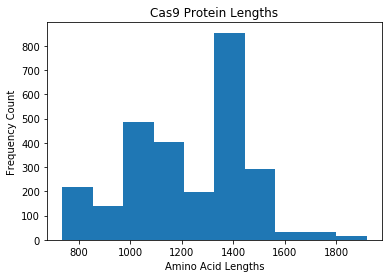

In [19]:
dist = []
for rec in parse("proteins/%s-Like-clustered.faa" % gene,"fasta"): dist.append(len(rec.seq))
dist = Series(dist)
plt.title("%s Protein Lengths" % gene)
plt.xlabel("Amino Acid Lengths")
plt.ylabel("Frequency Count")
hist = dist.hist(grid=False)
print "Total number of diverse proteins:", len(dist)

### Alignment

In [8]:
%%bash -s $gene
qsub alignment.sub
#mafft --maxiterate 1000 --globalpair --reorder --treeout $1-Like-clustered.faa > $1-Like-clustered.aln

### Profile the domains

In [4]:
spacePat = re.compile( r'^[\t ]*$')
hits=SamplesDict()
print "Reading Table Definitions"
for line in open("hmm/Cas9-Like-clustered_phi.faa.domtbl"):
    if line.startswith( '#' ):continue
    fields = re.split( r'(\[[^\[]*[^\S]+[^\]]*\]|[^\t ]+)', line.strip() )
    fields = DomainHit(filter(lambda i: not spacePat.search(i), fields))
    hits[fields.hit]=fields

Reading Table Definitions


In [5]:
noRuvC1,noRuvC3,neitherDomain,hasDomains, hasHNH, noHNH = set(), set(), set(), set(), set(),set()
colorScheme = {}
for sample in hits.samples:
    if sample in hits["RuvC_1_Cas9"] and sample in hits["RuvC_3_Cas9"]: #Has both
        colorScheme[sample]="#373D20"
        if sample in hits["HNH_Cas"]: hasDomains.add(sample)
        else: noHNH.add(sample)
    elif sample not in hits["RuvC_1_Cas9"] and sample not in hits["RuvC_3_Cas9"]: #Has neither
        colorScheme[sample]="#766153"
        neitherDomain.add(sample)
    elif sample in hits["RuvC_1_Cas9"]: #Has one but not the other
        colorScheme[sample]="#717744"
        noRuvC3.add(sample)
    elif sample in hits["RuvC_3_Cas9"]: #Has one but not the other
        colorScheme[sample]="#BCBD8B"
        noRuvC1.add(sample)
    elif sample not in hits["HNH_Cas"]:noHNH.add(sample)
        
htmlString ="""<table>
    """\
    "<tr style='background-color:#9B7E46;color:white'><td>Number of samples:</td><td>%i</td></tr>" % (len(hits.samples)) +\
    "<tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>%i</td></tr>" % (len(hasDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>%i</td></tr>" % (len(noRuvC1)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>%i</td></tr>" % (len(noRuvC3)) +\
    "<tr style='background-color:#766153;color:white'><td>Number of proteins with neither an RuvCI nor a RuvCIII</td><td>%i</td></tr>" % (len(neitherDomain)) +\
    "<tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>%i</td></tr>" % (len(noHNH)) +\
    """
    </table>
"""
display(HTML(htmlString))

Number of samples:,2635
Has all domains,2159
Number of sequences with no detected RuvCI domain,127
Number of sequences with no detected RuvCIII domain,63
Number of proteins with neither an RuvCI nor a RuvCIII,286
Number of sequences with no detected HnH,0


In [15]:
from Bio.SeqIO import index as fasta_index
allCas9s = fasta_index("Cas9-Like-clustered.faa", "fasta")

### Remove samples that don't start and end with an RuvC


Mean distance from RuvC_1 to start of protein: 23 std: 103

[2.102e+03 6.000e+00 0.000e+00 1.000e+00 0.000e+00 3.000e+00 7.000e+00
 3.000e+00 7.000e+00 3.000e+01] 



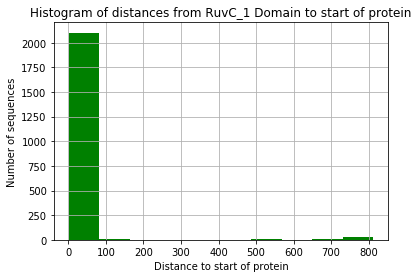

In [11]:
from pandas import Series
removeDomains = neitherDomain.union(noRuvC1.union(noRuvC3))
ruvC1Coords = []
ruvC3Coords = []
for sample in hits.samples:
    if sample in removeDomains:continue
    ruvC1Coords.append(hits.samples[sample]["RuvC_1_Cas9"].start) #,hits.samples[sample]["RuvC_1_Cas9"].end))
    ruvC3Coords.append(hits.samples[sample]["RuvC_3_Cas9"].end) #,hits.samples[sample]["RuvC_3_Cas9"].end))
    
series = Series(ruvC1Coords)
print "\nMean distance from RuvC_1 to start of protein: %.0f std: %.0f" % (series.mean(), series.std())

# the histogram of the data
n, bins, patches = plt.hist(series,facecolor='green')
print "\n",n,"\n"
plt.xlabel('Distance to start of protein')
plt.ylabel('Number of sequences')
plt.title("Histogram of distances from RuvC_1 Domain to start of protein")
plt.grid(True)
plt.show()


Mean distance from RuvC_3 to end of protein: 958 std: 136

[  5.   1. 177. 583. 171. 159. 718. 290.  43.  12.] 



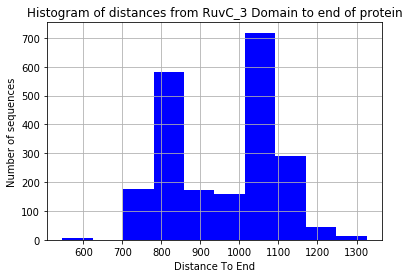

In [12]:
series = Series(ruvC3Coords)
print "\nMean distance from RuvC_3 to end of protein: %.0f std: %.0f" % (series.mean(), series.std())

# the histogram of the data
n, bins, patches = plt.hist(series,facecolor='blue')
print "\n",n,"\n"
plt.xlabel('Distance To End')
plt.ylabel('Number of sequences')
plt.title("Histogram of distances from RuvC_3 Domain to end of protein")
plt.grid(True)
plt.show()

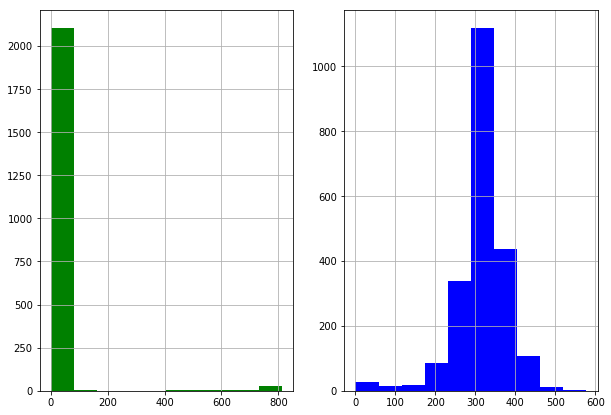

In [22]:
distanceMapperI,distanceMapperIII = {},{}
starts, ends=[],[]
for sample in allCas9s:
    if sample in removeDomains:continue
    try:distanceMapperI[hits.samples[sample]["RuvC_1_Cas9"].start].add(sample)
    except: distanceMapperI[hits.samples[sample]["RuvC_1_Cas9"].start]=set([sample])
    try:distanceMapperIII[hits.samples[sample]["RuvC_3_Cas9"].dend].add(sample)
    except: distanceMapperIII[hits.samples[sample]["RuvC_3_Cas9"].dend] = set([sample])
    ends.append(hits.samples[sample]["RuvC_3_Cas9"].dend)
    starts.append(hits.samples[sample]["RuvC_1_Cas9"].start)
start_series = Series(starts)
end_series = Series(ends)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 7))
ax1.hist(start_series,facecolor='green')
ax1.grid(True)
ax2.hist(end_series,facecolor='blue') 
plt.grid(True)
plt.show();

In [27]:
start_outliers = outliers(start_series,2) #RuvC1 outlier
start_outlierIDs,end_outlierIDs = set(),set()
for point in start_outliers: 
    for id in distanceMapperI[point]: start_outlierIDs.add(id)
end_outliers = outliers(end_series,2) #RuvC3 outlier
for point in end_outliers: 
    for id in distanceMapperIII[point]: end_outlierIDs.add(id)

htmlString ="""<table>
    """\
    "<tr style='background-color:#373D20;color:white'><td>No outlier domains</td><td>%i</td></tr>" % (len(hits.samples)-len(start_outlierIDs.union(end_outlierIDs))-len(removeDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of RuvC1 outliers</td><td>%i</td></tr>" % (len(start_outlierIDs)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of RuvC3 outliers</td><td>%i</td></tr>" % (len(end_outlierIDs)) +\
    "<tr style='background-color:#766153;color:white'><td>Number of with outlier in both</td><td>%i</td></tr>" % (len(start_outlierIDs.intersection(end_outlierIDs))) +\
    """
    </table>
"""
# htmlString += "<br/><img src='nwks/%s.png' style='width:1000px;height:1000px;'>" % ("Cas9-Subtree1.V2")
display(HTML(htmlString))  

No outlier domains,2023
Number of RuvC1 outliers,51
Number of RuvC3 outliers,86
Number of with outlier in both,1


In [41]:
import glob, os
outliers = start_outlierIDs.union(end_outlierIDs)
files = glob.glob("assemblies/*.fasta")
for fileName in files:
    fileName2 = fileName.replace("assemblies/","").replace(".fasta","")
#     if fileName2 in outliers: 
#         os.system("mv %s* assemblies/NoDomains/" % (fileName.replace(".fasta","")))
        
removeSeqs = set(hits.samples).difference(hasDomains)

print len(hits.samples), len(removeSeqs), len(hits.samples) - len(removeSeqs)
files = glob.glob("assemblies/*.fasta")
for fileName in files:
    fileName2 = fileName.replace("assemblies/","").replace(".fasta","")
#     if fileName2 not in hits.samples: 
#         os.system("mv %s* assemblies/NoDomains/" % (fileName.replace(".fasta","")))
print "Total Samples:",len(hits.samples)
print "\tMissing Domain Samples:",len(removeSeqs)
print "\tDomain profile Samples:",len(outliers)
print "After filtering:", len(hits.samples) - (len(removeSeqs) + len(outliers))

counter=0
fh = open("Cas9-Like-clustered2.faa","w")
from Bio.SeqIO import parse
for rec in parse("Cas9-Like-clustered.faa","fasta"):
    if os.path.exists("assemblies/%s.fa" % (rec.id)):
        counter += 1
        fh.write(">%s\n%s\n" % (rec.id, str(rec.seq)))
fh.close()

2635 476 2159
Total Samples: 2635
	Missing Domain Samples: 476
	Domain profile Samples: 136
After filtering: 2023
2023


In [3]:
from Bio.SeqIO import parse
fh = open("CasRelatedAssemblies2.fasta","w")
counter = 0
for rec in parse("CasRelatedAssemblies.fasta","fasta"):
    if os.path.exists("assemblies/%s.fa" % (rec.id)):
        counter += 1
        fh.write(">%s\n%s\n" % (rec.id, str(rec.seq)))
fh.close()
print counter

2023


In [40]:
%%bash
pwd

/mnt/research/germs/shane/transActRNA/data


In [45]:
files1 = set(glob.glob("assemblies/*.fasta"))
files2 = set(glob.glob("assemblies/*.fa"))
fastas,fas =set(),set()
for f in files2: fas.add(f.replace(".fa",""))
for f in files1: fastas.add(f.replace(".fasta",""))
for f in fas.difference(fastas):
    os.system("rm %s*" % (f))

In [7]:
### Remove missing domains and length filtering
# Domain database pfam
# wget ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/Pfam-A.full.gz
dom_counter = {}
for line in open("/mnt/research/germs/shane/transActRNA/data/domains/Cas9-Like-clustered.faa.domtbl"):
    if "#" in line:continue
    rec = line.strip().split("    ")
#     print rec
#     break
    try:dom_counter[line.strip()]+=1
    except:dom_counter[line.strip()]=1
dom_counter = Counter(dom_counter)

In [19]:
from Bio.SearchIO import HmmerIO
from Bio.SearchIO.HmmerIO import Hmmer3DomtabHmmhitParser as hmmParser

In [25]:
hasHNH, hasRuvC= set(), set()
for x in hmmParser(open("/mnt/research/germs/shane/transActRNA/data/domains/DiverseCas9s1.domtbl")):
    if "HNH" == x.id:
        print x.id, len(x.hits)
        for hit in x.hits: hasHNH.add(hit.id)
    elif "RuvC" == x.id:
        print x.id, len(x.hits)
        for hit in x.hits: hasRuvC.add(hit.id)

HNH 83
RuvC 76


In [26]:
print "Number of proteins with both:", len(hasHNH.intersection(hasRuvC))


Number of proteins with both: 75


In [23]:
for x in hmmParser(open("/mnt/research/germs/shane/CRISPR_Cas/data/domains/DiverseCas9s1.domtbl")):
    if "ruvc" in x.id.lower():
        print x.id, len(x.hits)
        for hit in x.hits:
            print "\t",hit.id

RuvC 76
	lcl|NC_011898.1_prot_YP_002507391.1_1
	lcl|NC_005090.1_prot_NP_907605.1_1
	lcl|NZ_ADEF01000013.1_prot_ZP_06288774.1_1
	lcl|NC_002663.1_prot_NP_246064.1_1
	lcl|NZ_JH815207.1_prot_ZP_11022414.1_1
	lcl|NC_014935.1_prot_YP_004168469.1_1
	lcl|NC_003116.1_prot_YP_002342100.1_1
	lcl|AJFQ01000005.1_prot_EIE39736.1_1
	lcl|NC_013949.1_prot_YP_003516037.1_1
	lcl|NC_016001.1_prot_YP_004843922.1_1
	lcl|NZ_ADKM02000013.1_prot_ZP_08157403.1_1
	lcl|NZ_ACFY01000144.1_prot_ZP_03755025.1_1
	lcl|NZ_JH932293.1_prot_ZP_17295095.1_1
	lcl|NZ_AFHO01000003.1_prot_ZP_09312133.1_1
	lcl|NZ_DS483477.1_prot_ZP_02077990.1_1
	lcl|NZ_GL622352.1_prot_ZP_07912707.1_1
	lcl|NC_003228.3_prot_YP_213533.1_1
	lcl|AECD01000042.1_prot_EFT93846.1_1
	lcl|NZ_ADVE01000017.1_prot_ZP_06887976.1_1
	lcl|NC_016630.1_prot_YP_005054169.1_1
	lcl|NC_014633.1_prot_YP_003968716.1_1
	lcl|NC_002967.9_prot_NP_970941.1_1
	lcl|NZ_AEOS01000293.1_prot_ZP_08574780.1_1
	lcl|CP001873.1_prot_ADC31648.1_1
	lcl|NC_012781.1_prot_YP_002937591.1_1
	l

In [58]:
definitions, descriptors, AC = {}, set(['AC','DE']), ""
important = set(["Cas9","nuclease","endonuclease", "HNH", "HnH", "RuvC", "ruvc", "RUVC", "HNH/ENDO", "CRISPR"])
for line in open("domains/Pfam-A.full"):
    rec = line.strip().split()
    if len(rec)<3 or rec[1] not in descriptors: continue
    if rec[1] == 'AC':AC = rec[2]
    else: definitions[AC] = " ".join(rec[2:])
print "Completed Loading %i definitions" % len(definitions)

Completed Loading 16479 definitions


In [59]:
hnhDomainIDs = set()
for val in dom_counter.most_common(100):
    id,count = val[0], val[1]
    print "%s\t%i\t%s" % (id,count,definitions[id])
#     if "hnh" in definitions[id].lower():
#         hnhDomainIDs.add(id)
#         print "%s\t%i\t%s" % (id,count,definitions[id])
#     if "ruvc" in definitions[id].lower():
#         print "%s\t%i\t%s" % (id,count,definitions[id])

PF13395.5	2348	HNH endonuclease
PF14279.5	2323	HNH endonuclease
PF07510.10	2047	Protein of unknown function (DUF1524)
PF01844.22	2016	HNH endonuclease
PF02075.16	1961	Crossover junction endodeoxyribonuclease RuvC
PF16592.4	1914	REC lobe of CRISPR-associated endonuclease Cas9
PF03652.14	1857	Holliday junction resolvase
PF14239.5	1550	RRXRR protein
PF16593.4	1424	Bridge helix of CRISPR-associated endonuclease Cas9
PF04231.12	1380	Endonuclease I
PF04250.12	962	Protein of unknown function (DUF429)
PF07066.10	849	Lactococcus phage M3 protein
PF00370.20	819	FGGY family of carbohydrate kinases, N-terminal domain
PF13391.5	811	HNH endonuclease
PF16595.4	641	PAM-interacting domain of CRISPR-associated endonuclease Cas9
PF00424.17	601	REV protein (anti-repression trans-activator protein)
PF02463.18	528	RecF/RecN/SMC N terminal domain
PF01411.18	522	tRNA synthetases class II (A)
PF03564.14	481	Protein of unknown function (DUF1759)
PF13499.5	436	EF-hand domain pair
PF13393.5	429	Histidyl-tRNA synt

In [9]:
from Bio.SeqIO import parse
ids = set()
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): ids.add(rec.id[:-5])
db_path = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
for id in ids:
    os.system("cp %s/%s assemblies/" % (db_path,assembly_ids[id]))


CP012042_ORF3


In [ ]:
import pickle
from Bio.SeqIO import parse
db_path = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
files = os.listdir(db_path)
assembly_ids = {}
for fileName in files:
    for rec in parse(os.path.join(db_path,fileName),"fasta"): assembly_ids[rec.id]=fileName
print len(assembly_ids)
pickle.dump(assembly_ids,open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","wb"))

In [3]:
from Bio.SeqIO import parse
import os
import pickle
print "Loading ncbi IDs"
assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","rb"))
print "Loading patric2 IDs"
notInNCBI, ids,fullID = [], [], {}
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): 
    fullID[rec.id[:-5]] = rec.id
    ids.append(rec.id[:-5])
for id in ids:
    if id not in assembly_ids:
        notInNCBI.append(id)
        continue
    os.system("cp /mnt/research/germs/shane/databases/assemblies/NCBI/refseq/%s /mnt/research/germs/shane/CRISPR_Cas/data/assemblies/%s.fasta" % (assembly_ids[id],fullID[id]))
    print id,assembly_ids[id]


Loading ncbi IDs
Loading patric2 IDs
NZ_JQBT01000012.1 GCF_001438685.1.fasta
NZ_PIWR01000017.1 GCF_002834905.1.fasta
NZ_MLBH01000003.1 GCF_001832975.1.fasta
NZ_NPAE01000004.1 GCF_002775895.1.fasta
NZ_FQUC01000030.1 GCF_900128985.1.fasta
NZ_KQ969157.1 GCF_001578805.1.fasta
NZ_AJTI01000057.1 GCF_000261225.1.fasta
NZ_BAMJ01000014.1 GCF_000615805.1.fasta
NZ_BCMI01000011.1 GCF_002217985.1.fasta
NZ_FNZD01000010.1 GCF_900109215.1.fasta
NZ_PQHA01000002.1 GCF_002915795.1.fasta
NZ_KQ960576.1 GCF_001553225.1.fasta
NZ_ASRY01000315.1 GCF_000520815.1.fasta
NZ_MJZP01000038.1 GCF_001763885.1.fasta
NZ_AUHI01000006.1 GCF_000423105.1.fasta
NZ_MNAC01000010.1 GCF_001855735.1.fasta
NZ_JVCG01000024.1 GCF_001076575.1.fasta
NZ_GL575016.1 GCF_000184535.1.fasta
NZ_GL575017.1 GCF_000184535.1.fasta
NZ_MJVN01000051.1 GCF_001761705.1.fasta
NZ_FUZE01000012.1 GCF_900168205.1.fasta
NZ_MJEE01000005.1 GCF_002077535.1.fasta
NZ_ALSD01000016.1 GCF_000289375.1.fasta
NZ_CBVI010000055.1 GCF_000513195.1.fasta
NZ_OAHP01000020.1 

In [5]:
print "Loading PATRIC IDs"
assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/PATRIC2/pat2_manifest.p","rb"))
print "Copying Files"
for id in notInNCBI:
    os.system("cp /mnt/research/germs/shane/databases/assemblies/PATRIC2/fastas/%s /mnt/research/germs/shane/CRISPR_Cas/data/assemblies/%s.fasta" % (assembly_ids[id],fullID[id]))
    print id,assembly_ids[id]

Loading PATRIC IDs
Copying Files
PDOR01000016 2026720.8.fna
NMQD01001102 2019665.3.fna
PCUU01000002 1973954.3.fna
PFSG01000055 1975542.3.fna
LOXX01000052 1637841.3.fna
AGZF01000029 883094.3.fna
DHKH01000001 1952331.3.fna
MEPN01000057 1797376.3.fna
QENY01000006 1703337.3.fna
KN150933 28450.136.fna
MENR01000030 1797328.3.fna
NYVI01000024 2021391.9.fna
DJNA01000060 1950332.3.fna
LJSF01000002 1666913.4.fna
MUWF01000003 95486.261.fna
PALG01000023 1871037.64.fna
PALG01000030 1871037.64.fna
DLAB01000001 1945965.3.fna
DJBJ01000023 253.35.fna
PFSS01000039 1973991.3.fna
DKRG01000032 1951475.3.fna
NYZS01000080 1979400.3.fna
1765.172.con.18 1765.172.fna
DGGF01000016 253.31.fna
DFUO01000017 1951606.3.fna
MKTX01000015 1895834.3.fna
AWNW01000035 1379305.3.fna
AWNW01000054 1379305.3.fna
ONYW01000007 172733.11.fna
HF988672 1262874.3.fna
NMUI01000396 284016.3.fna
MHEF01000135 1801703.3.fna
DFFQ01000012 1952054.3.fna
PDRY01000013 1948890.12.fna
MGZB01000041 1798308.3.fna
PANU01000057 1871037.68.fna
LJUD0

In [9]:
#assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","rb"))
#assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/PATRIC2/pat2_manifest.p","rb"))
files = os.listdir("assemblies")
ids = set()
for fileName in files:ids.add(fileName.replace(".fasta",""))
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): 
    if rec.id not in ids:
        print rec.id,assembly_ids[rec.id[:-5]]

 NZ_KB908299.1_ORF1 GCF_000382425.1.fasta


In [ ]:
%%bash
cd scripts
bash pilercrRun.sh &
bash pilercrRunFW.sh

In [1]:
from ete3 import Tree, TreeStyle
# casTree=Tree("Cas9-Like-clustered.faa.tree")
# ts = TreeStyle()
# ts.mode = "c"
# ts.show_leaf_name = False
# casTree.render("Cas9.png",tree_style=ts)
#t.write(format=1, outfile="new_tree.nw")

In [ ]:
from ete3 import Tree, TreeStyle
rooted_tree = Tree( "((A,B),(C,D));" )
ts = TreeStyle()
ts.mode = "c"
rooted_tree.render("%%inline",tree_style=ts)

In [17]:
from pandas import DataFrame, read_csv, Series
outfmt6_cols = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"]
blastResults = read_csv("data/DiverseCompare.blastout",delimiter='\t', names=outfmt6_cols) 
len(blastResults)
blastResults
len(blastResults[blastResults.pident>90])

2379

In [18]:
len(blastResults[blastResults.pident>98])

1983

2159


In [49]:
%%bash
ls

annotateAssembly_cmds_1b1-100.sh
annotateAssembly_cmds_1b1-1.sh
annotateAssembly_cmds_1b1-200.sh
annotateAssembly_cmds_1b1-300.sh
annotateAssembly_cmds_1b1-400.sh
annotateAssembly_cmds_1b1-500.sh
annotateAssembly_cmds_1b1-600.sh
annotateAssembly_cmds_1b1-700.sh
annotateAssembly_cmds_1b1-800.sh
annotateAssembly_cmds_1b1-900.sh
annotations
assemblies
blastout
Cas9-Like-clustered.faa
Cas9-Like-clustered.faa.aln
Cas9-Like-clustered.faa.clstr
Cas9-Like-clustered.faa.tree
Cas9-Like.faa
CasRelatedAssemblies.fasta
conseqs0
crisprs
crisprs2
data
diverseCas9s
DiverseCas9s.aln
DiverseCas9s.faa
DiverseCas9s.faa.tree
DiverseCas9s.hmm
domains
hmmSearch
logs
pickles
PredictedTracrRNAs.fa
PredictedTracrRNAs.grouped.fasta
PredictedTracrRNAs.grouped.fasta.clstr
tmp
